# Project

## We open our csv file containing NAO index values as a pandas dataframe and our NetCDF file containing SST values within the Caribbean Region as an xarray dataset.
$\text{SST(X,Y)} : X \in (-100^{\circ},-50^{\circ}), Y \in(5,40)$

In [480]:
import xarray as xr

import pandas as pd

#xarray dataset containing gridded SST values
ds = xr.open_dataset('/Users/dessyb/Box/Patrick/ERA5/caribbean_sst.nc') 

#pandas dataframe containing columns for year, month and index values for NAO
nao = pd.read_csv('/Users/dessyb/Box/Patrick/ERA5/nao.csv') 

## Changing the index of the nao dataframe to a datetime column

In [481]:
import datetime

#placing date variables into a separate dataframe
date_df = nao[["year","month","day"]]

#creating datetime column
dates_column = pd.to_datetime(date_df)

#setting index to datetime variable

nao.index = pd.to_datetime(dates_column)

#viewing first 5 rows of nao dataframe
nao.head()

,year,month,day,index
1979-01-01,1979,1,1,-1.38
1979-02-01,1979,2,1,-0.67
1979-03-01,1979,3,1,0.78
1979-04-01,1979,4,1,-1.71
1979-05-01,1979,5,1,-1.03


## We are interested only in the winter relationship. To facilitate this we create a mask of the indices holding data for winter months DJF

In [482]:
import numpy as np

#creates a variable that identifies season, where winter = 1, spring =2, summer =3, autumn =4
seasons = np.array(nao['month']%12 // 3 + 1)

#transposes seasons to a one dimensional column array
seasons = np.transpose(seasons, axes=None)

#extracting the indices for all winter months (i.e. month == 1)
winter = [i for i, x in enumerate(seasons) if x == 1]

## Adjust years to ensure each winter period reflects the same year

In [492]:
#taking subset of nao index values for winter months only
nao_winter = nao['index'][winter]

#Extracting winter years and months
years = np.array(nao["year"][winter])
months = np.array(nao["month"][winter])

#Decrementing the year for January and February to facilitate grouby.mean
for i in range(len(years)): 
    
    if months[i] == 1 or months[i] == 2:
        
        years[i] -= 1

## Averaging nao index values over each winter season

In [495]:
#Creating dataframe to facilitate grouby.mean
df_smooth = pd.DataFrame({"year":years,"nao":nao_winter})

#Performing mean over each winter period
nao_winter_avg = df_smooth.groupby('year').mean()

#view winter averages
nao_winter_avg.head()

,nao
year,
1978,-1.025000
1979,0.100000
1980,0.690000
1981,0.080000
1982,0.946667


## Recreating the DJF NAO index plot

Text(0.5, 1.0, 'DFJ NAO Index 1979 to 2021')

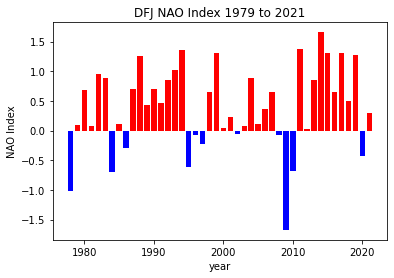

In [515]:
#creating an array to store the color of positive (red) vs negative (blue) indices
colors_nao = []

for i in range(len(nao_winter_avg)):
    
    if nao_winter_avg['nao'].iloc[i] >= 0:
        
        colors_nao.append('red')
        
    else:
        
        colors_nao.append('blue')

#Making bar chart
plt.bar(nao_winter_avg.index,nao_winter_avg['nao'],color=colors_nao)

plt.xlabel("year")
plt.ylabel("NAO Index")
plt.title("DFJ NAO Index 1979 to 2021")

## Creating correlation matrix to store correlation values at each grid point

In [422]:
#length of longitude array in netcdf file
ilon = len(ds.longitude)

#length of latitude array in netcdf file
ilat = len(ds.latitude) 

#matrix for correlations values across grid
corr_matrix = np.array([[np.nan]*ilon]*ilat) 

print(ilat, ilon, corr_matrix.shape)

141 201 (141, 201)


## Populating Correlation matrix by iterating through the correlation matrix

## This requires several steps at each grid point; including:

#### - Removing missing values
#### - Performing a grouby mean
#### - Detrending the SST values
#### - Calculating the Pearson's Correlation coefficent
#### - Set the value at that specific point within the matrix grid

In [428]:
import scipy.stats
from scipy import signal

#for loop calculates correlation across grid
for i in range(ilon): 
    for j in range(ilat):
        
        #putting the year, nao and SST values into a dataframe to facilitate the averageing
        corr_df = pd.DataFrame({'year':years,'nao':nao_winter,'sst':np.array(ds.sst[0:516,0,j,i])[winter]})
        
        #removing missing data
        corr_df = corr_df[corr_df['nao'].notna()]
        corr_df = corr_df[corr_df['sst'].notna()]
        
        #overwriting NaN in corr matrix over water (i.e. if the dataframe has data after removal of NaNs)
        if len(corr_df) > 0:
            
            #performing grouby mean uisng year
            corr_df = corr_df.groupby('year').mean()
            
            #performing detrending of SST values and corr coefficient calculation
            corr_matrix[j][i]=scipy.stats.pearsonr(corr_df['nao'],signal.detrend(corr_df['sst']))[0]

## Creating Contour Plot of Correlation Values

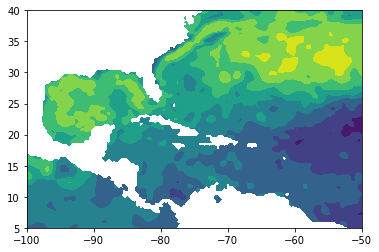

In [432]:
import matplotlib.pyplot as plt

#creating a colour filled contour plot of the correlation matrix
plt.contourf(ds.longitude, ds.latitude,corr_matrix)

/var/folders/0s/y7jwzcpd30g7fmswyypr08s80000gn/T/ipykernel_82455/4175321187.py:33: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(filled_c, orientation='vertical',shrink = 0.5,ticks=np.arange(-0.4,0.8,0.2))


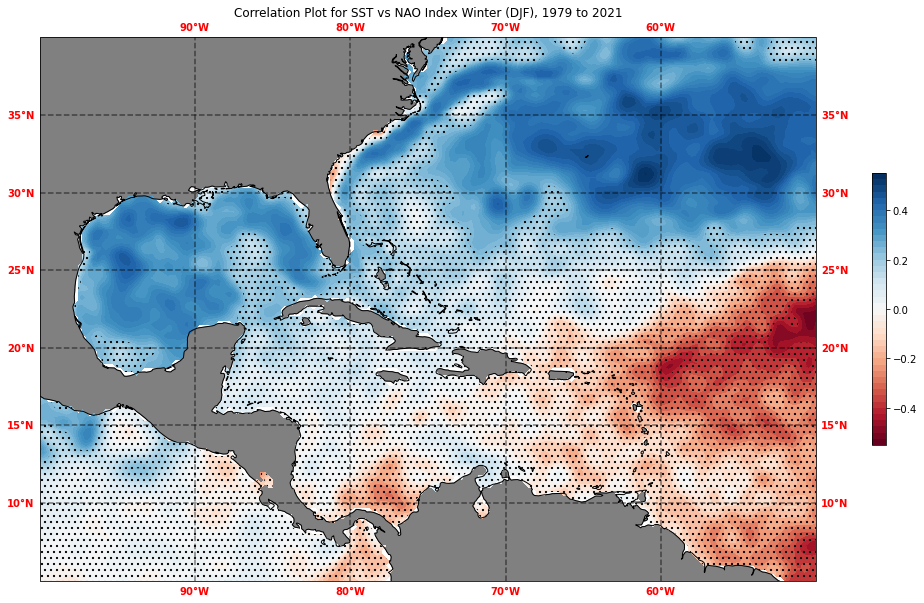

In [429]:
class MidpointNormalize(colors.Normalize): #midpoint 
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        # Note also that we must extrapolate beyond vmin/vmax
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1.]
        return np.ma.masked_array(np.interp(value, x, y,
                                            left=-np.inf, right=np.inf))

midnorm = MidpointNormalize(vmin=np.nanmin(corr_matrix), vcenter=0, vmax=np.nanmax(corr_matrix))

ax.coastlines()

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND,facecolor=("grey"))
ax.add_feature(cfeature.COASTLINE)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1.5, color='black', alpha=0.5, linestyle='--')


gl.xlabel_style = {'color': 'red', 'weight': 'bold','size': 10}
gl.ylabel_style = {'color': 'red', 'weight': 'bold','size': 10}

levels = [corr_matrix.min(), 0.3, corr_matrix.max()]

fig.colorbar(filled_c, orientation='vertical',shrink = 0.5,ticks=np.arange(-0.4,0.8,0.2))

#levels=levels, hatches=["", "."], alpha=0

plt.title("Correlation Plot for SST vs NAO Index Winter (DJF), 1979 to 2021")

filled_c = ax.contourf(ds.longitude, ds.latitude, corr_matrix,transform=ccrs.PlateCarree(),cmap='RdBu',levels=50,norm=midnorm)

ax.contourf(ds.longitude, ds.latitude,corr_matrix,transform=ccrs.PlateCarree(),levels=[-0.3,0.3],norm=midnorm,hatches=[".."],alpha=0)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,2*np.pi,100)
y = np.sin(x) + np.random.random(100) * 0.8

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.plot(x, y)
plt.plot(x, smooth(y,3))
plt.plot(x, smooth(y,19))

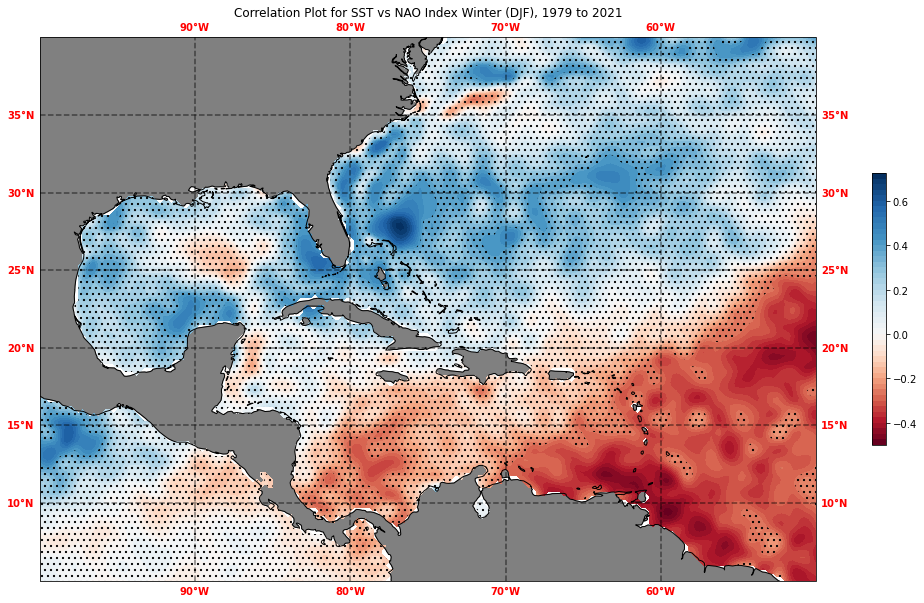

In [382]:
fig

In [346]:
len(smooth(y,3))

100

In [347]:
len(smooth(y,19))

100

In [ ]:
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature


import matplotlib.ticker as mticker
import matplotlib.colors as colors

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER



In [ ]:


print(len(nao_winter))



#nao['index'].plot(kind='bar',color=nao.positive.map({True: 'b', False: 'r'}))

#plt.bar(nao['year'][winter],nao_winter)